In [8]:
import hmftpy as hmf
from hmftpy.plaquettes.triangular import plaq9d, plaq9p
from hmftpy.operators import mf_ops, inner_hamiltonian, periodic_hamiltonian
from hmftpy import do_hmft
from quspin.basis import spin_basis_1d
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

basis = spin_basis_1d(9, pauli=0)
ops = hmf.operators.mf_ops(plaq9d, basis)
maxit = 50

In [15]:
J2s_12 = np.linspace(.5, 0, 20)
l = len(J2s_12)
labels = ['inner', 'periodic', 'lr', 'rl']
energies_12 = {lab: np.zeros(l) for lab in labels}
mfs_12 = {lab: [None] for lab in labels}
cvgs_12 = {lab: np.zeros(l) for lab in labels}
plaq = plaq9p

print('Running right to left')

for i, J2 in enumerate(tqdm(J2s_12)):
    interactions = {'local': {},
                    'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                    'n_nearest': {'xx': J2, 'yy': J2, 'zz': 0},
                    'n_n_nearest': {}}
    Hi = inner_hamiltonian(plaq, interactions, basis)
    e, v = Hi.eigsh(k=1, which='SA', tol=10**-12)
    energies_12['inner'][i] = e[0]
    Hp = periodic_hamiltonian(plaq, interactions, basis)
    e, v = Hp.eigsh(k=1, which='SA', tol=10**-12)
    energies_12['periodic'][i] = e[0]

    energies_12['rl'][i], v, mf, cvg = do_hmft(plaq, interactions, basis, 
                                                           max_iter=maxit, mf0=mfs_12['rl'][-1], 
                                                           ops=ops, Hi=Hi,
                                                           mf_cvg=False)
    cvgs_12['rl'][i] = cvg
    mfs_12['rl'] += [mf]

    
print('Running left to right')

for i, J2 in enumerate(tqdm(J2s_12[::-1])):
    interactions = {'local': {},
                    'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                    'n_nearest': {'xx': J2, 'yy': J2, 'zz': 0},
                    'n_n_nearest': {}}
    try:
        energies_12['lr'][i], v, mf, cvg = do_hmft(plaq, interactions, basis, 
                                                               max_iter=maxit, mf0=mfs_12['lr'][-1], 
                                                               ops=ops,
                                                               mf_cvg=False)
    except:
        print('Failure at J2 = {}. Probably 0 mfs. Retrying with random MF'.format(J2))
        energies_12['lr'][i], v, mf, cvg = do_hmft(plaq, interactions, basis, 
                                                               max_iter=maxit, mf0=None, 
                                                               ops=ops,
                                                               mf_cvg=False)    
    mfs_12['lr'] += [mf]
    # chis_12['lr'][i] = np.real(chi_op.expt_value(v))
    cvgs_12['lr'][i] = cvg



  0%|          | 0/20 [00:00<?, ?it/s]

Running right to left


  0%|          | 0/20 [00:00<?, ?it/s]

Running left to right


100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


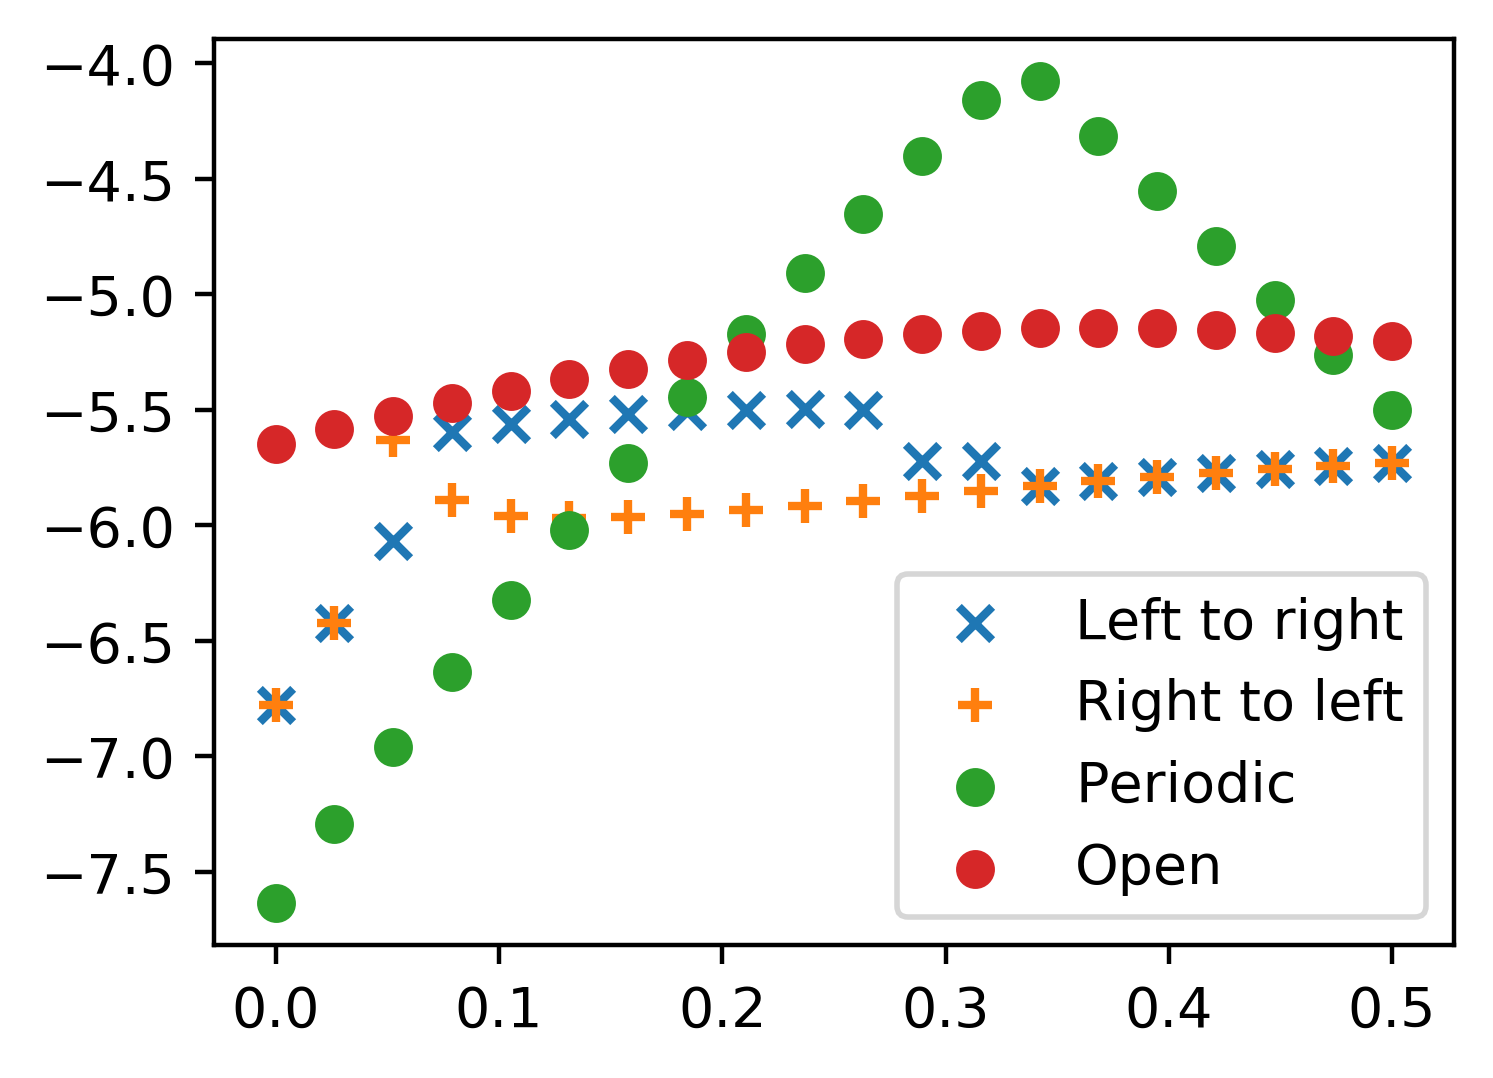

In [16]:
plt.figure(figsize=(4,3), dpi=400)
plt.scatter(J2s_12, energies_12['lr'][::-1], label='Left to right', marker='x')
plt.scatter(J2s_12, energies_12['rl'], label='Right to left', marker='+')
plt.scatter(J2s_12, energies_12['periodic'], label='Periodic')
plt.scatter(J2s_12, energies_12['inner'], label='Open')
plt.legend()